The data used in this ipython notebook is on dalma.abudhabi.nyu.edu. This notebook should be run on that server

In [1]:
%pylab inline
from matplotlib import colors
rcParams['savefig.dpi'] = 100

/home/ndb245/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:816: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/ndb245/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())


Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys

if '' in sys.path:
    sys.path.remove('') # needed so that home directory isn't included

from gnl.plots import plotiter
import gnl.xarray
import xarray as xr

Load the averaged moments data from the SAM simulation. This folder is rsynced from dalma. Drop the first 10 days of the simulation. These data consist of statistical moments calculated with sub-domains with a size of $\Delta x = 40$ km.

In [3]:
data_root = "/scratch/ndb245/SAM6.10.9/OUT_MOMENTS/"

In [4]:
moments = "/scratch/ndb245/SAM6.10.9/OUT_MOMENTS/WALKER*.nc"

data = xr.open_mfdataset(moments)
data = data.sel(time=slice(10, None))

this flux data needs to be decomposed into eddy and mean field contributions

# Resolved and unresolved momentum sources

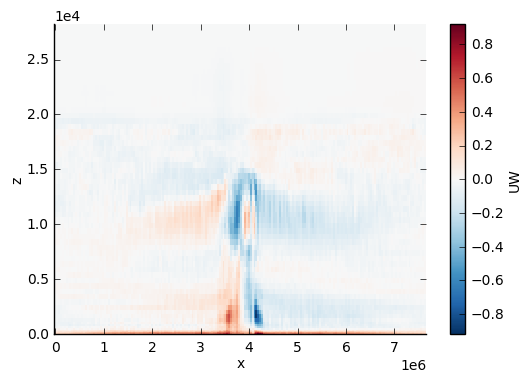

In [5]:
data.UW.mean('time').plot()

The eddy contribution to this overall flux can be computed using the formula

$$ \overline{uw} = \overline{u}\overline{w} + \overline{u' w'} $$

In [6]:
eddy_uw = data.UW - data.U1 * data.W1

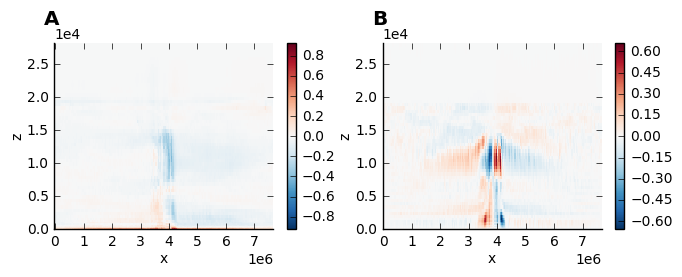

In [7]:
pt = plotiter(range(3), w=4,aspect=.6)
next(pt)

eddy_uw.mean('time').plot(label='eddy uw')
next(pt)
(data.U1*data.W1).mean('time').plot(label='mean uw')

To compute the vertical flux divergence of these quantities, I need the base state density profile. The CMT in an anelastic model is given by

$$ F_{CMT} = - \frac{1}{\rho_0} \frac{\partial}{\partial z} \rho_0 u'w' $$

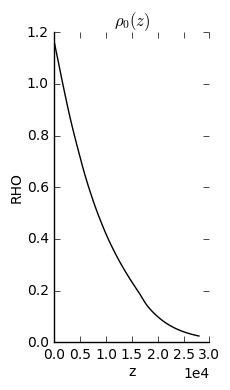

In [5]:
stat_filename = "/scratch/ndb245/SAM6.10.9/OUT_STAT/WALKER_2km_4096x1_64_2000m_15s.WALKER_2K.nc"
stats = xr.open_dataset(stat_filename)
rho0_tot = stats.RHO.isel(time=0)

plt.figure(figsize=(2,4))
rho0_tot.plot()
plt.title(r"$\rho_0(z)$");

Let's compute the formulas given for $F_{CMT}$ using standard centered differencing formulas in the interior, and first order differences at the boundaries.

In [6]:
def vert_div(flux, z, axis=0):
    """ Compute the vertical derivate of quantity
    
    Uses second order centered diffences inside the domain, and first order at the boundaries.
    """
    if flux.ndim > 1:
        flux = np.rollaxis(flux, axis)
    div  = flux.copy()
    
    nz = z.shape[0]
    
    assert flux.shape[0] == nz
    for i in range(nz):
        if i==0:
            div[i] = (flux[i+1]-flux[i])/(z[i+1]-z[i])
            
        elif i==nz-1:
            div[i] = (flux[i]-flux[i-1])/(z[i]-z[i-1])
            
        else:
            div[i] = (flux[i+1] -flux[i-1])/(z[i+1] - z[i-1])
        
    if flux.ndim > 1:
        return np.rollaxis(div, 0, start=axis+1) 
    else:
        return div

def anelastic_vert_div(da, rho0=rho0_tot, z=data.z):
    """Compute the anelastic flux divergence given by
    
    .. math: 
          \frac{1}{\rho_0} \frac{\partial}{\partial z} \rho_0 \cdot
    """

    flux, zg = (da * rho0).values, z.values
    div = vert_div(flux, zg, axis=1)

    da_div = da.copy()

    da_div.values = div
    
    return da_div/rho0

In [7]:
fcmt, fresolve, ftot = (-anelastic_vert_div(data.UW - data.U1 * data.W1), 
                        -anelastic_vert_div(data.U1 * data.W1), 
                        -anelastic_vert_div(data.UW))

Here are plots of the time mean momentum sources for the resolved, unresolved, and total.

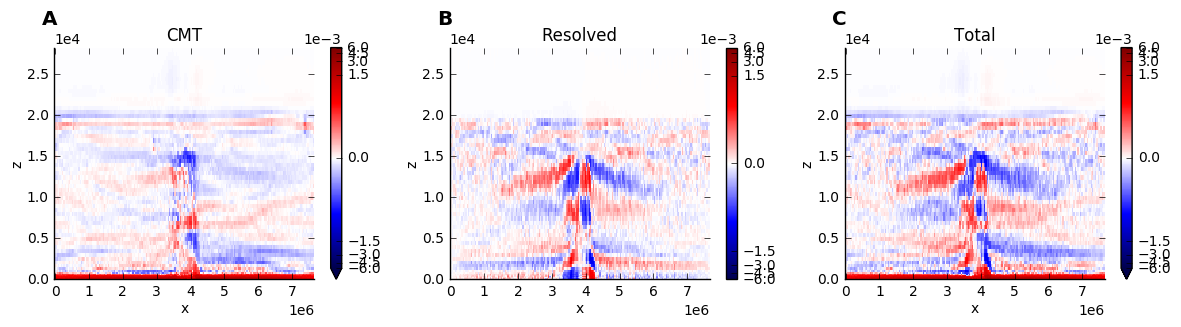

In [11]:
from matplotlib.colors import SymLogNorm
for k, v in plotiter([('CMT', fcmt), ('Resolved', fresolve), ('Total', ftot)],
                     w=4, aspect=.8):

    v.mean('time').plot(norm=SymLogNorm(1e-4), 
                        vmin=-6e-3, vmax=6e-3,
                        cmap='seismic')
    plt.title(k)

The magnitude of the CMT and Resolved momentum transport (RMT) are similar. Interestingly, it seems that the CMT is not symmetric about the warm pool, while the RMT is. These quantities have the units of acceleration.

We can look at correlation between CMT and U1 over the domain, and we see a quasiperiodic structure in time.

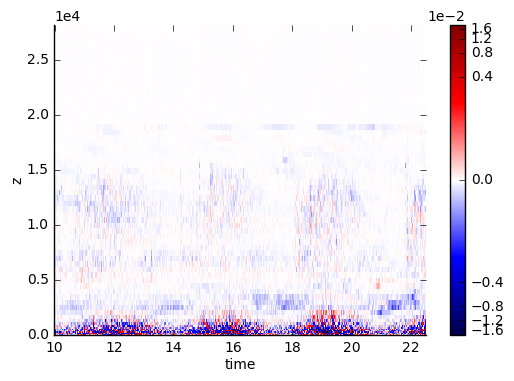

In [12]:
(fcmt * data.U1 * rho0_tot).mean('x').plot(x='time', y='z', 
                        norm=SymLogNorm(1e-3), 
                        cmap='seismic')

Effective damping coefficient

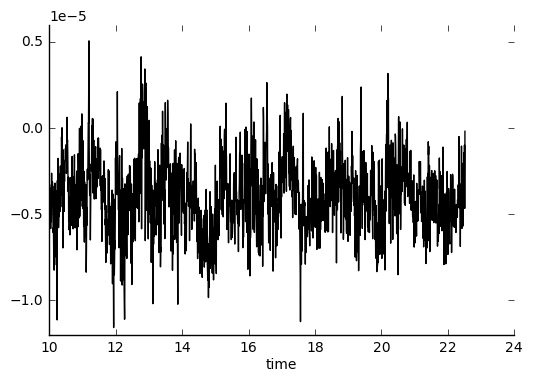

In [13]:
keff = (fcmt * data.U1 * rho0_tot**2).mean(['x', 'z'])/((data.U2 * rho0_tot**2).mean(['x','z']))
keff.plot()

It seems that the majority of the up-scale momentum transport comes from the resolved scales. However, there are domain averaged upscale effects of CMT.

# EOF analysis of the vertical wind field

In [14]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import scale

In [15]:
troposphere = dict(z=slice(500,None))

rho0 = rho0_tot.sel(**troposphere)

weight = (rho0/rho0.integrate('z'))

w = (data.W1*np.sqrt(weight)).sel(**troposphere)
w.shape

(1803, 59, 192)

Roll the array so the space and time dimensions are cosidered samples, and the vertical direction is the feature space. In sklearn, the datasets must by (nsamples, nfeatures) so features are contiguous in memory

In [16]:
w_int = w - w.mean('time')

X = np.rollaxis(w_int.values, 1, 3).reshape((-1, w.z.shape[0]))

Let's ask for 5 vertical modes

In [17]:
n_modes = 8

In [18]:
pca = PCA(n_components=n_modes)

pca.fit(X)

PCA(copy=True, n_components=8, whiten=False)

The calculation above does invariant to the sign of the projected mode. Therefore, we define the vertical modes so that they are positive near the surface.

In [19]:
for i in range(n_modes):
    pca.components_[i] *= np.sign(pca.components_[i,2])

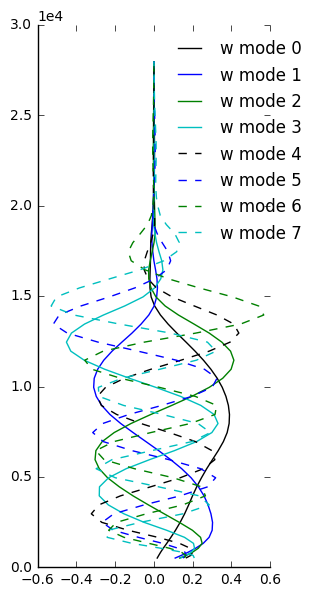

In [20]:
modes= [pca.components_[i]/np.sqrt(rho0) for i in range(n_modes)]
plt.figure(figsize=(3,7))
for i in range(n_modes):
    plot(modes[i], modes[i].z, label='w mode {}'.format(i))
    
legend(bbox_to_anchor=(1.2,1))

These modes seem to match the sinusoidal vertical modes nicely, and are much easier to generate than the Kasahari modes. The horizontal velocity modes are much messier for some reason. What does the horizontal structure of the climatological wind field look like? I have plotted the x integral of the projected vertical velocities below. This is basically related to the structure of the horizontal wind field.

these are the explained variance ratios:

In [21]:
pca.explained_variance_ratio_

array([ 0.44295314,  0.19772795,  0.1122567 ,  0.07376197,  0.04403944,
        0.02933405,  0.01969436,  0.01444067])

## Vertical spectral of the horizontal momentum equation

Let the w modes be given by $\phi_m(z)$ and the u modes are then given by $\psi_m(z) = \rho_0^{-1} \partial_z (\rho_0 \phi_m)$. The w modes are orthogonal with respect to the inner product defined by
$$ (f,g) = \frac{\int_0^{z_{top}} f g \rho_0(z)}{ \int_0^{z_{top}} \rho_0(z) dz}$$.

However, unfortunately the u modes are not orthogonal. This makes calculating spectrum of horizontal momentum source terms non-trival. We cannot just project onto a convenient basis of orthogonal modes. However, from the divergence-free condition, it is clear that the indefinite integral of $u$ can be expanded in terms of the $\phi_m$. Let L be the operator defined by 

The divergence free condition is $u_x + \rho_0^{-1} (\rho_0 w)_z = 0$. Then, if we define a linear operator given by
$$L u = \frac{1}{\rho_0(z)} \int_0^z \rho_0(z') u(z')dz',$$
the divergence anelastic incompressibility condition becomes $Lu = -w$. This indicates that the quantity $Lu$ can be naturally expressed in the same basis as $w$, and provides a nice path towards using the spectral decomposition of $w$ to study the horizontal momentum and it's source terms

In [22]:
from gnl.xarray import XRReshaper

def transform_ulike(u, rho0, wtransformer):
    """Transform a u quantity using PCA for w
    
    Parameters
    ----------
    u: DataArray
    rho0: DataArray
    wtransform: sklearn transformer
    
    Returns
    -------
    uproj: numpy array
    """
    weight = np.sqrt(rho0/rho0.sum())
    
    Lu = np.cumsum(u*rho0, axis=u.get_axis_num('z'))/rho0.sum()
    
    Lu *= weight
    rs = XRReshaper(Lu)
    
    lu_array = rs.to_flat('z')
    
    uproj =  pca.transform(lu_array)
    
    return rs.from_flat(uproj, 'z', 'm')


def transform_wlike(w, rho0, wtransformer):
    """Transform a w-like quantity using PCA for w
    
    Parameters
    ----------
    w: DataArray
    rho0: DataArray
    wtransform: sklearn transformer
    
    Returns
    -------
    wproj: numpy array
    """
    weight = np.sqrt(rho0/rho0.sum())
    w = w *weight
    
    rs = XRReshaper(w)
    w = rs.to_flat('z')
    wproj =  pca.transform(w)
    
    return rs.from_flat(wproj, 'z', 'm')

In particular this, transformation can be used to compute the climatological vertical spectrum of $u$. These are the modes which are analogous to the baroclinic modes in the multicloud model.

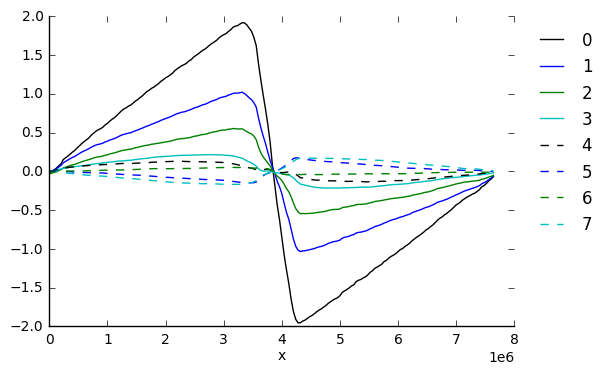

In [23]:
uproj = transform_ulike(data.U1.mean('time'), rho0, pca)


for m in uproj.m:
    
    uproj.sel(m=m).plot()
title('')

legend(range(n_modes), bbox_to_anchor=(1.2,1))

The sign of these projections matches the velocity in the lower atmosphere.

## vertical modes and cmt

Applying the transformation $L$ to the CMT (or any other flux divergence terms) yields a simplification.
\begin{align}
L \frac{1}{\rho_0}\partial_z \rho_0 F  =& \frac{1}{\rho_0(z)} \int_0^z \partial_z \rho_0(z) F dz'\\
                                      =& \frac{\rho_0(z) F(z) - \rho_0(0)F(0)}{\rho_0(z)}\\
                                      =& F(z) - F(0)\frac{\rho_0(0)}{\rho_0(z)}
\end{align}
Of course, when the flux $F$ vanishes at the surface we recover the flux $F$. This is case with vertical momentum transport (although not necessary for "eddy momentum transport"). It is necessary to account for this surface flux when performing vertical spectra. More specifically, we remove this surface contribtion before performing the spectral projection of a given flux divergence term. This is accomplished by performing the decomposition on a surface adjusted flux $\tilde{F} = F + F(0) \frac{\rho_0(0)}{\rho_0(z)}$.

In [24]:
eddy_uw_proj = transform_wlike(-eddy_uw.mean('time'), rho0, pca)

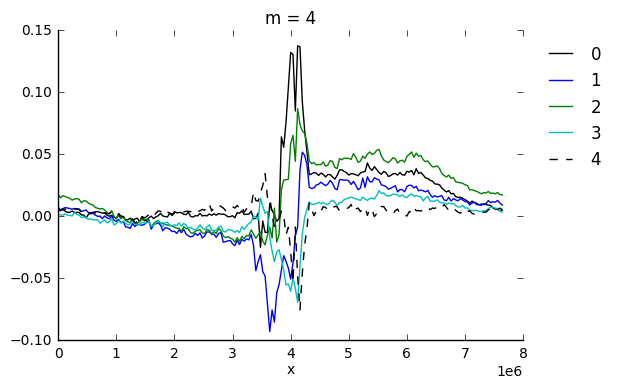

In [25]:
for m in range(5):
    eddy_uw_proj.sel(m=m).plot(label=m)

    
legend(bbox_to_anchor=(1.2,1))

These are the time mean eddy flux components. They are very noisy, so we should probably make longer simulations. Overall the eddy flux spectral components appear to have the opposite sign as the mean climatological momentum projections.

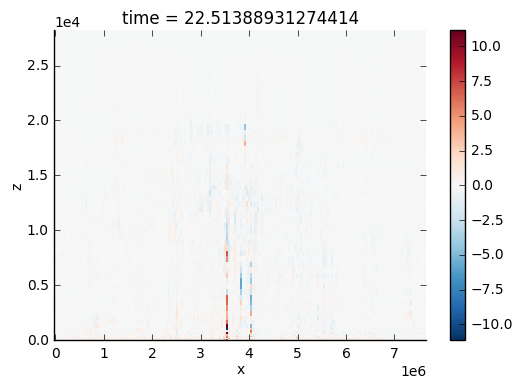

In [26]:
euwt = eddy_uw.isel(time=-1)
euwt.plot()

Here is a single snapshot of the vertical spectrum of CMT.

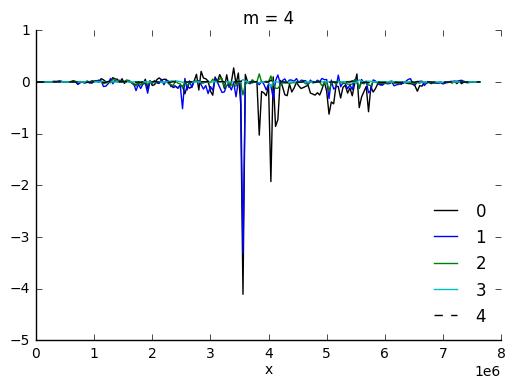

In [27]:
time_index = -1

cmt_snap_proj = transform_wlike(-eddy_uw.isel(time=time_index), rho0, pca)
u_snap_proj = transform_ulike(data.U1.isel(time=time_index), rho0, pca)


plotd = cmt_snap_proj * u_snap_proj

for m in range(5):
    plotd.sel(m=m).plot(label=m)
legend(range(5), loc="lower right")

In [28]:
from tqdm import tqdm_notebook

In [29]:
def batch_apply(func, da, args=()):

    l = []

    batch_size = 50
    batch_start = range(0, len(da.time), batch_size)

    for ibatch in tqdm_notebook(batch_start):
        time = slice(ibatch, ibatch+batch_size)
        l.append(func(da.isel(time=time), *args))
        
    return xr.concat(l, 'time')

In [30]:
import os

In [19]:
try:
    ds = xr.open_dataset(data_root +"projected_vars.nc")
    
    uproj = ds.u
    uwproj = ds.uwp
    UWproj = ds.UW
except:
    uproj  = batch_apply(transform_ulike, data.U1, args=(rho0, pca))
    uwproj = batch_apply(transform_wlike, -eddy_uw, args=(rho0, pca))
    UWproj = batch_apply(transform_wlike, -(data.U1 * data.W1), args=(rho0, pca))
    
    xr.Dataset({'u': uproj, 'uwp': uwproj, 'UW': UWproj}).to_netcdf(data_root +"projected_vars.nc")

In [32]:
def mt_plot(m, **kw):

    pt = plotiter(range(3),w=4, aspect=.6)
    next(pt)
    uproj.sel(m=m, **kw).plot()

    next(pt)
    uwproj.sel(m=m, **kw).plot(norm=colors.SymLogNorm(0.05))

    next(pt)
    UWproj.sel(m=m, **kw).plot(norm=colors.SymLogNorm(0.5))

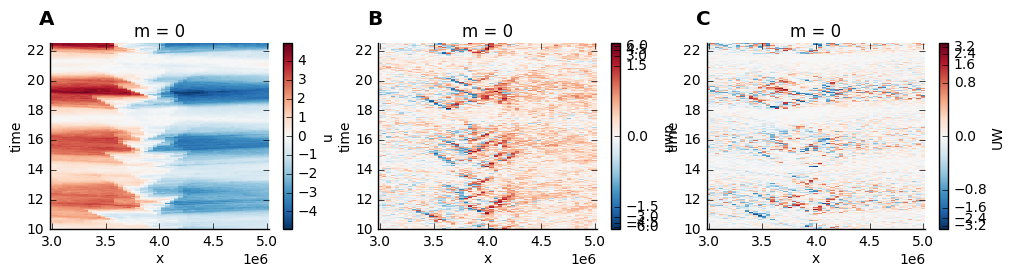

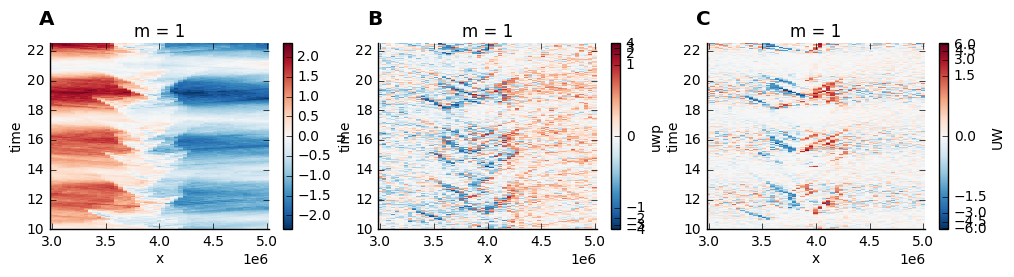

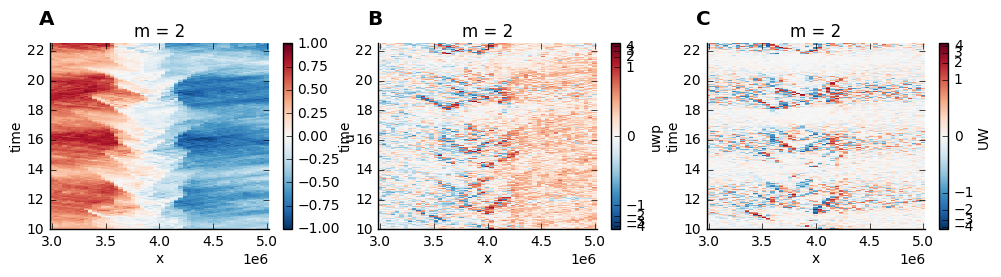

In [33]:
for i in range(3):
    mt_plot(i, x=slice(3e6, 5e6))


This is the downscale CMT

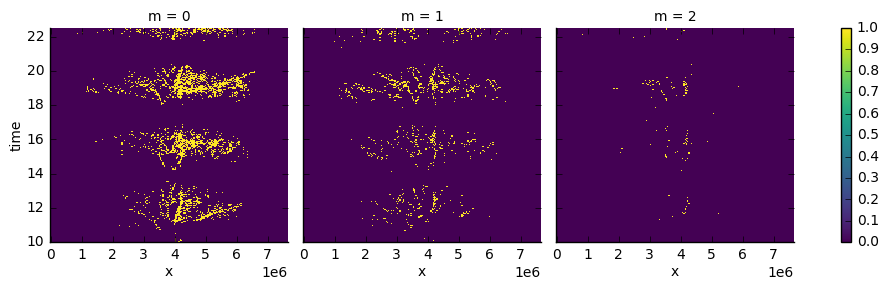

In [34]:
downscale = (uwproj * uproj) < np.percentile(uwproj * uproj, 1)

downscale.sel(m=range(3)).plot(col='m', col_wrap=3)

This is the upscale

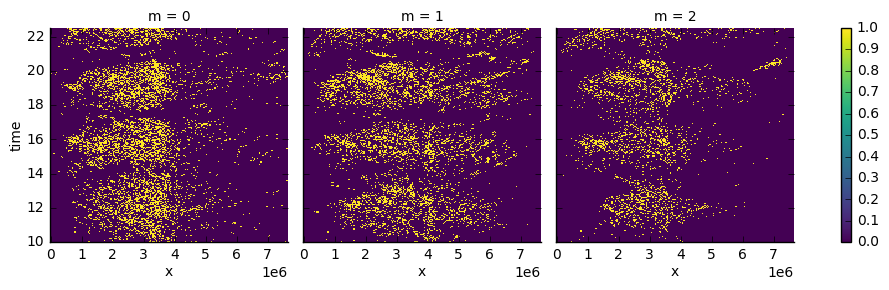

In [35]:
upscale = (uwproj * uproj) > np.percentile(uwproj * uproj, 95)

upscale.sel(m=range(3)).plot(col='m', col_wrap=3)

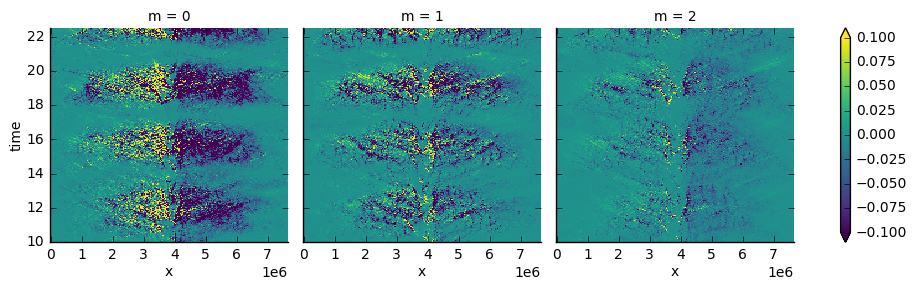

In [23]:
(uwproj * uproj).sel(m=range(3)).plot(col='m', vmin=-1e-1, vmax=1e-1)

Why is there an apparent assymetry in the CMT for the first mode in particular? The left side of the domain has much more upscale CMT.

### Vertical structure of CMT

In [ ]:
pca_cmt = PCA(5)

rs = XRReshaper(eddy_uw.sel(**troposphere) * np.sqrt(rho0))

pca_cmt.fit(rs.to_flat('z'))

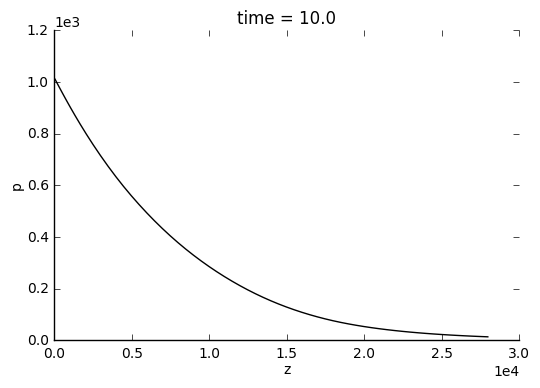

In [14]:
data.p.isel(time=0).plot()

In [117]:
pca_cmt.explained_variance_ratio_

array([ 0.10151285,  0.08918572,  0.08514353,  0.07257325,  0.06903638])

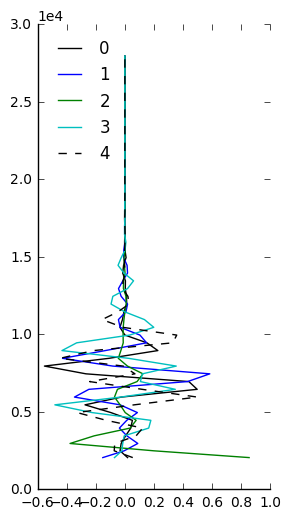

In [118]:
plt.figure(figsize=(3,6))
plot(pca_cmt.components_.T, rs._da.z);
legend(range(5), loc="upper left")

This next work looks at $CMT_{corr} = u_1 \cdot F_{CMT}^1$ where $u_1 = u(4 km) - u(14 km)$, and likewise for $F_{CMT}^1$. This measure is not sensitive to surface related CMT. $CMT_{corr}$ should be positive if the CMT is upscale and negative when it is downscale.

In [15]:
def calcmode1(fcmt):

     return fcmt.isel(z=np.searchsorted(fcmt.z, 2.5e3)) - fcmt.isel(z=np.searchsorted(fcmt.z, 14e3))

cmtu1 = calcmode1(fcmt)
u1 = calcmode1(data.U1)

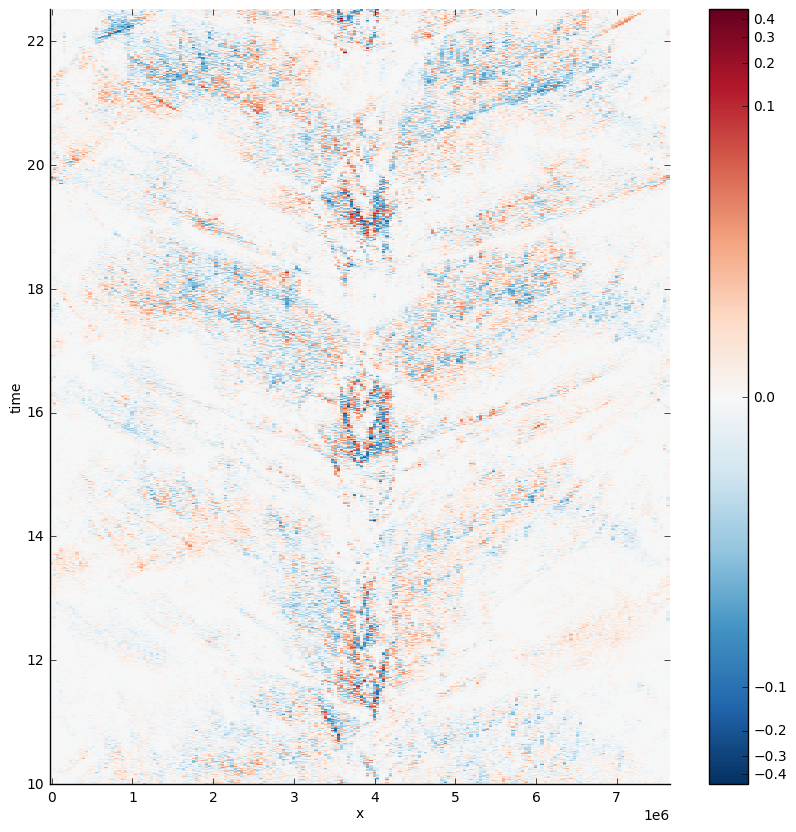

In [17]:
plt.figure(figsize=(10,10))

corrcmt = cmtu1 * u1

(corrcmt).plot(norm=colors.SymLogNorm(np.percentile(abs(corrcmt), 90)))

There is both upscale and downscale CMT associated with convective activity in the warm pool region.